<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c2_rock_paper_scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [61]:
%matplotlib inline

import pathlib
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast
from tensorflow.keras.layers.experimental.preprocessing import RandomHeight

In [20]:
BATCH_SIZE = 126
IMG_SIZE = (150, 150)
INPUT_SHAPE = (150, 150, 3)

In [3]:
train_zip_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
validation_zip_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'

train_path_to_zip = tf.keras.utils.get_file('rps.zip', 
                                            origin=train_zip_url,
                                            extract=True)

validation_path_to_zip = tf.keras.utils.get_file('rps-test.zip', 
                                                 origin=validation_zip_url,
                                                 extract=True)

train_path = os.path.join(os.path.dirname(train_path_to_zip), 'rps')
validation_path = os.path.join(os.path.dirname(validation_path_to_zip), 
                               'rps-test-set')

print(f'train_path_to_zip: {train_path_to_zip}')
print(f'validation_path_to_zip: {validation_path_to_zip}')
print(f'train_path: {train_path}')
print(f'validation_path: {validation_path}')

train_path_to_zip: /root/.keras/datasets/rps.zip
validation_path_to_zip: /root/.keras/datasets/rps-test.zip
train_path: /root/.keras/datasets/rps
validation_path: /root/.keras/datasets/rps-test-set


In [4]:
train_ds = image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

validation_ds = image_dataset_from_directory(
    directory=validation_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
assert train_ds.class_names == validation_ds.class_names
class_names

['paper', 'rock', 'scissors']

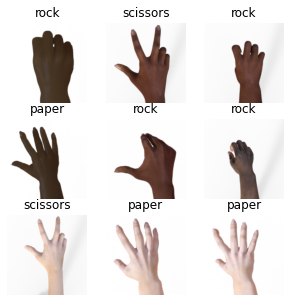

In [6]:
plt.figure(figsize=(5, 5))
images, labels =  next(iter(train_ds.take(1)))
print()
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype('uint8'))
  plt.title(class_names[np.argmax(labels[i])])
  plt.axis('off')

In [7]:
image_batch, labels_batch = next(iter(train_ds))
image_batch.shape, labels.shape

(TensorShape([126, 150, 150, 3]), TensorShape([126, 3]))

In [9]:
normalization_layer = Rescaling(1.0/255.0)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
np.min(first_image), np.max(first_image)

(0.06960785, 1.0)

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [72]:
data_augmentation = Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.2),
  RandomZoom(0.1),
  RandomContrast(0.1),
  #RandomHeight(0.2)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


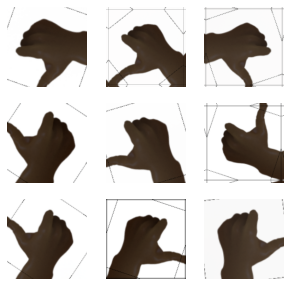

In [73]:
image, _ = next(iter(train_ds.take(1)))
plt.figure(figsize=(5, 5))
first_image = image[0]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

In [74]:
model = tf.keras.models.Sequential([
    Rescaling(1.0/255.0),
    #normalization_layer,
    data_augmentation,
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    layers.Conv2D(64, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The fourth convolution
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    layers.Dropout(0.5),
    # 512 neuron hidden layer
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [89]:
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)


In [76]:
history = model.fit(
    train_ds, 
    epochs=25, 
    steps_per_epoch=20, 
    validation_data = validation_ds, 
    verbose = 1, 
    validation_steps=3
)


Epoch 1/25
20/20 [==============================] - 2s 82ms/step - loss: 1.8207 - accuracy: 0.3829 - val_loss: 1.0757 - val_accuracy: 0.5081
Epoch 2/25
20/20 [==============================] - 2s 77ms/step - loss: 1.0011 - accuracy: 0.5262 - val_loss: 1.0385 - val_accuracy: 0.6048
Epoch 3/25
20/20 [==============================] - 2s 77ms/step - loss: 0.8103 - accuracy: 0.6421 - val_loss: 0.7866 - val_accuracy: 0.5968
Epoch 4/25
20/20 [==============================] - 2s 77ms/step - loss: 0.5396 - accuracy: 0.7806 - val_loss: 0.5443 - val_accuracy: 0.7473
Epoch 5/25
20/20 [==============================] - 2s 78ms/step - loss: 0.4280 - accuracy: 0.8429 - val_loss: 0.3438 - val_accuracy: 0.8306
Epoch 6/25
20/20 [==============================] - 2s 77ms/step - loss: 0.2807 - accuracy: 0.8933 - val_loss: 0.3069 - val_accuracy: 0.8790
Epoch 7/25
20/20 [==============================] - 2s 77ms/step - loss: 0.2275 - accuracy: 0.9230 - val_loss: 0.1489 - val_accuracy: 0.9624
Epoch 8/25
20

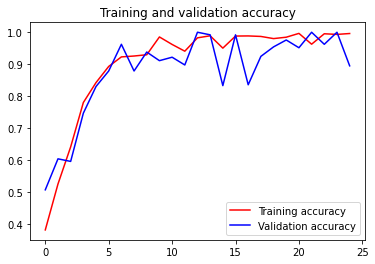

<Figure size 432x288 with 0 Axes>

In [77]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [88]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
  print(class_names[np.argmax(classes)])

Saving scissors3.jpg to scissors3 (1).jpg
scissors3.jpg
[[9.7130501e-01 9.1230072e-07 2.8693989e-02]]
paper
